In [4]:
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

In [5]:
%matplotlib inline
#from preamble import *
%watermark -v -p sklearn,numpy,scipy,matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import math

ERROR:root:Line magic function `%watermark` not found.


In [6]:
import pandas as pd
import numpy as np
from collections import Counter
import pickle

from tqdm import tqdm_notebook
import numpy

fname = 'data/prediction_data.csv'
data = pd.read_csv(fname)
data2 = data
data = data.iloc[:,9:]

In [7]:
data2.tail()

,League,MatchID,Match_Date,Home_Name,Away_Name,Home_GF,Away_GF,Result,Season,Home_IAR,...,pass_by_Clear_3,LOP_by_touch_3,Shots_3,OP_3,CA_3,CR_3,Tackles_3,RATE_3,Touch_3,Save_ratio_3
11746,BUNDES,1294579,180922,Wolfsburg,Freiburg,NaN,NaN,NaN,1819,6.610,...,0.460195,0.472499,0.500000,0.517857,0.500000,0.805556,0.446281,0.515598,0.524338,0.570271
11747,BUNDES,1294580,180922,Nuernberg,Hannover 96,NaN,NaN,NaN,1819,6.820,...,0.563957,0.541142,0.518072,0.500000,0.997009,0.301887,0.558559,0.496484,0.470358,0.282908
11748,BUNDES,1294572,180922,Schalke 04,Bayern Munich,NaN,NaN,NaN,1819,0.000,...,0.569223,0.588957,0.402174,0.328125,0.997009,0.275362,0.598131,0.476534,0.391798,0.407036
11749,BUNDES,1294574,180923,Bayer Leverkusen,Mainz 05,NaN,NaN,NaN,1819,5.760,...,0.541807,0.451163,0.767442,0.784615,0.998502,0.246154,0.459184,0.500625,0.541287,0.359684
11750,BUNDES,1294576,180923,Eintracht Frankfurt,RasenBallsport Leipzig,NaN,NaN,NaN,1819,6.645,...,0.476364,0.585456,0.484848,0.489362,0.750000,0.482353,0.449153,0.499750,0.474399,0.432747


In [8]:
data2.shape

(11751, 53)

In [9]:
Train_TSNE = False

In [10]:
%%time
if Train_TSNE == True:
    from sklearn.manifold import TSNE
    model = TSNE(n_components=2, learning_rate=100, perplexity=20, method='barnes_hut')
    transformed = model.fit_transform(data)
    transformed = pd.DataFrame(data=transformed, columns=['1','2'])
    
    transformed['League'] = data2.iloc[:,0]
    transformed['Match_Date'] = data2.iloc[:,2]
    transformed['Home'] = data2.iloc[:,3]
    transformed['Away'] = data2.iloc[:,4]

    goal_difference = [g - l for g, l in zip(data2['Home_GF'], data2['Away_GF'])]
    transformed['G differ'] = goal_difference
    transformed['Season'] = data2['Season']
    
    with open('data/pickle/TSNE.pkl', 'wb') as f:
        pickle.dump(transformed, f)
    
else:
    with open('data/pickle/TSNE.pkl', 'rb') as f:
        transformed = pickle.load(f)

Wall time: 178 ms


In [11]:
Gdiffer = transformed['G differ']
abs_Gdiffer = [abs(i) for i in Gdiffer]
transformed['abs G differ'] = abs_Gdiffer

results = []

for i in transformed['G differ']:
    if i == 0:
        results.append('Draw')
    elif i < 0:
        results.append('Lose')
    else:
        results.append('Win')

transformed['Results'] = results

In [12]:
transformed.head()

,1,2,League,Match_Date,Home,Away,G differ,abs G differ,Results
0,-53.555923,-5.301250,LALIGA,100828,Hercules,Athletic Bilbao,-1.0,1.0,Lose
1,-27.657864,-13.160050,LALIGA,100828,Malaga,Valencia,-2.0,2.0,Lose
2,-58.598991,-19.049711,LALIGA,100828,Levante,Sevilla,-3.0,3.0,Lose
3,-31.784355,-13.249558,LALIGA,100829,Espanyol,Getafe,2.0,2.0,Win
4,-24.946957,-13.231486,LALIGA,100829,Real Sociedad,Villarreal,1.0,1.0,Win


In [13]:
transformed = pd.concat([transformed, data2[['Home_GF', 'Away_GF']]], axis=1)
transformed = transformed.iloc[:]

In [14]:
def softmax(x):
    import numpy as np
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [16]:
def predict_match(result, distance):
    import math
    win, draw, lose = 0, 0, 0
    for i, j in zip(result, distance):
        coefficient = 1/math.exp(math.sqrt(j))
        if i == 0:win += coefficient * 1
        elif i == 1:draw += coefficient * 1
        else:lose += coefficient * 1

    win_prob = 0.2*win
    draw_prob = 0.2*draw
    lose_prob = 0.2*lose
    prob = [win_prob, draw_prob, lose_prob]
    #return softmax(prob)
    yield softmax(prob)

In [17]:
def Euclidean(targetdata, data):
    for idx, i in enumerate(data):
        temp = 0
        for j in range(len(i)):
            temp += (targetdata[j] - i[j]) ** 2
        temp = temp ** (1/2)
        yield (temp, idx)

In [18]:
def get_similar_matches(data_, date, home_team, topn = 10, print_plt = True):

    xy = data_[['1', '2']].values
    target_match = data_[['1', '2']][(data_['Match_Date'] == date) & (data_['Home'] == home_team)].values
    similar_list = list(Euclidean(target_match[0], xy))
    similar_list.sort(reverse=False)
    target_index = similar_list[0][1]
    similar_list = similar_list[1 :topn +1]
    distance, results = [], []
    matchtitle = str(data_.loc[target_index,'Match_Date']) + ' ' + data_.loc[target_index, 'Home'] + ' vs ' + data_.loc[target_index, 'Away']

    print(matchtitle,' - ', data_.loc[target_index,'Results'],'\n')
    
    for i in similar_list:
        index = i[1]
        distance.append(i[0])
        
        if data_.loc[index, 'Home_GF'] == data_.loc[index, 'Away_GF']: results.append(1)
        elif data_.loc[index, 'Home_GF'] > data_.loc[index, 'Away_GF']: results.append(0)
        else: results.append(2)
        
        print('{} - {} vs {} - {} : {}   Distance : {:.3f}'.format(data_.loc[index,'Match_Date'], data_.loc[index, 'Home'], data_.loc[index, 'Away'], 
                                                                     int(data_.loc[index, 'Home_GF']), int(data_.loc[index, 'Away_GF']), i[0]))
    
    predict = list(predict_match(results, distance))[0]
    print('\n', predict)
    
    if print_plt == True:
        plt.figure(figsize=(18,12))

        colors = ["yellow", "blue", "red"]
        cmap = sns.color_palette(colors)
        markers = ["o", "x", "+"]
        ax = sns.scatterplot(x='1', y='2', hue = 'Results', size='abs G differ',sizes=(20, 300), hue_norm=(0, 3), style='Results',data = transformed)
        random_index = [i for i in similar_list[1:topn+1]]

        for idx, i in enumerate(random_index):
            plt.annotate('', (data_.loc[i[1] ,'1'], data_.loc[i[1], '2']),
                        xytext=(data_.loc[i[1] ,'1'] +5, data_.loc[i[1], '2'] +5),
                             arrowprops=dict(facecolor='black', shrink=0.15),)
            plt.rcParams.update({'font.size': 20})

        plt.annotate(matchtitle, (data_.loc[target_index ,'1'], data_.loc[target_index, '2']),
                         xytext=(data_.loc[target_index ,'1'] +5, data_.loc[target_index, '2'] +5),
                         arrowprops=dict(facecolor='red', shrink=0.05),)
        plt.show()

180113 Eintracht Frankfurt vs Freiburg  -  Draw 

170506 - Leicester vs Watford - 3 : 0   Distance : 0.089
101113 - West Ham vs Blackpool - 0 : 0   Distance : 0.627
150221 - Crystal Palace vs Arsenal - 1 : 2   Distance : 0.822
161120 - Crotone vs Torino - 0 : 2   Distance : 0.850
170228 - Malaga vs Real Betis - 1 : 2   Distance : 1.094
170114 - Leganes vs Athletic Bilbao - 0 : 0   Distance : 1.173
161210 - Watford vs Everton - 3 : 2   Distance : 1.306
180113 - Hannover 96 vs Mainz 05 - 3 : 2   Distance : 1.308
121020 - West Ham vs Southampton - 4 : 1   Distance : 1.523
110423 - Sunderland vs Wigan - 4 : 2   Distance : 1.748

 [0.37733146 0.30008312 0.32258542]


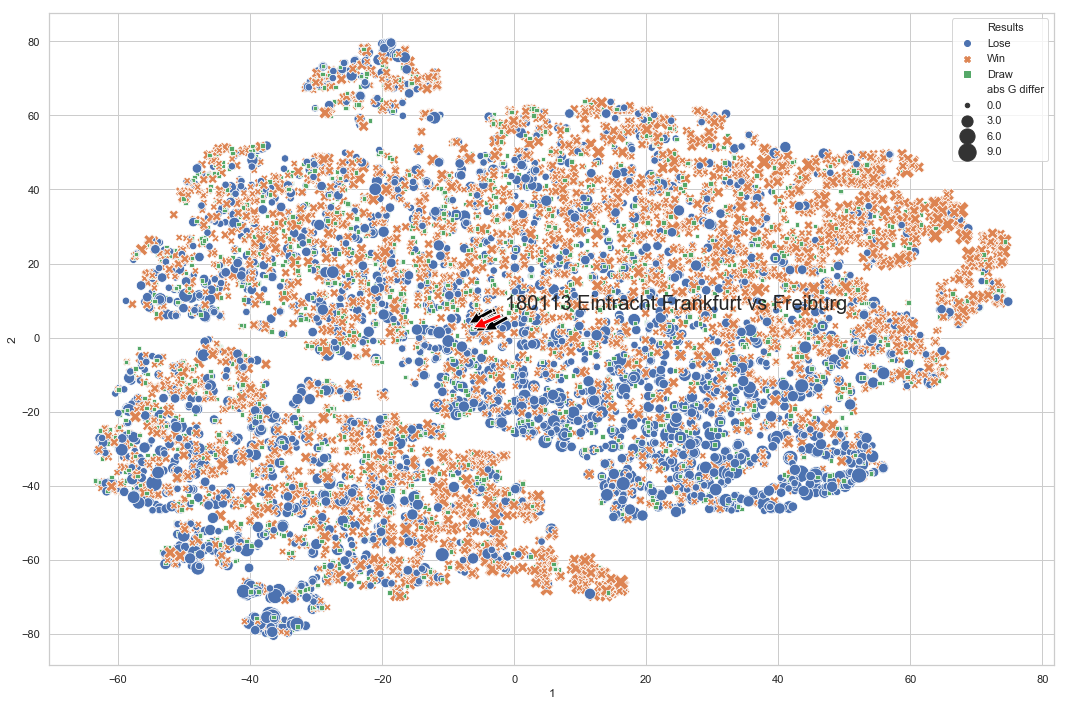

In [19]:
from random import randint
randIdx = randint(0,len(transformed))

date_ = transformed.loc[randIdx, 'Match_Date']
home_ = transformed.loc[randIdx, 'Home']
get_similar_matches(transformed, date_, home_, topn=10, print_plt=True)

180422 Manchester City vs Swansea  -  Win 

180120 - Manchester City vs Newcastle United - 3 : 1   Distance : 0.398
150814 - Bayern Munich vs Hamburger SV - 5 : 0   Distance : 0.420
170506 - Bayern Munich vs Darmstadt - 1 : 0   Distance : 0.465
170415 - Napoli vs Udinese - 3 : 0   Distance : 0.829
150425 - Bayern Munich vs Hertha Berlin - 1 : 0   Distance : 1.171
150523 - Bayern Munich vs Mainz 05 - 2 : 0   Distance : 1.195
171021 - Manchester City vs Burnley - 3 : 0   Distance : 1.262
180509 - Manchester City vs Brighton - 3 : 1   Distance : 1.418
151212 - Bayern Munich vs Ingolstadt - 2 : 0   Distance : 1.460
180819 - Manchester City vs Huddersfield - 6 : 1   Distance : 1.495

 [0.51966891 0.24016555 0.24016555]


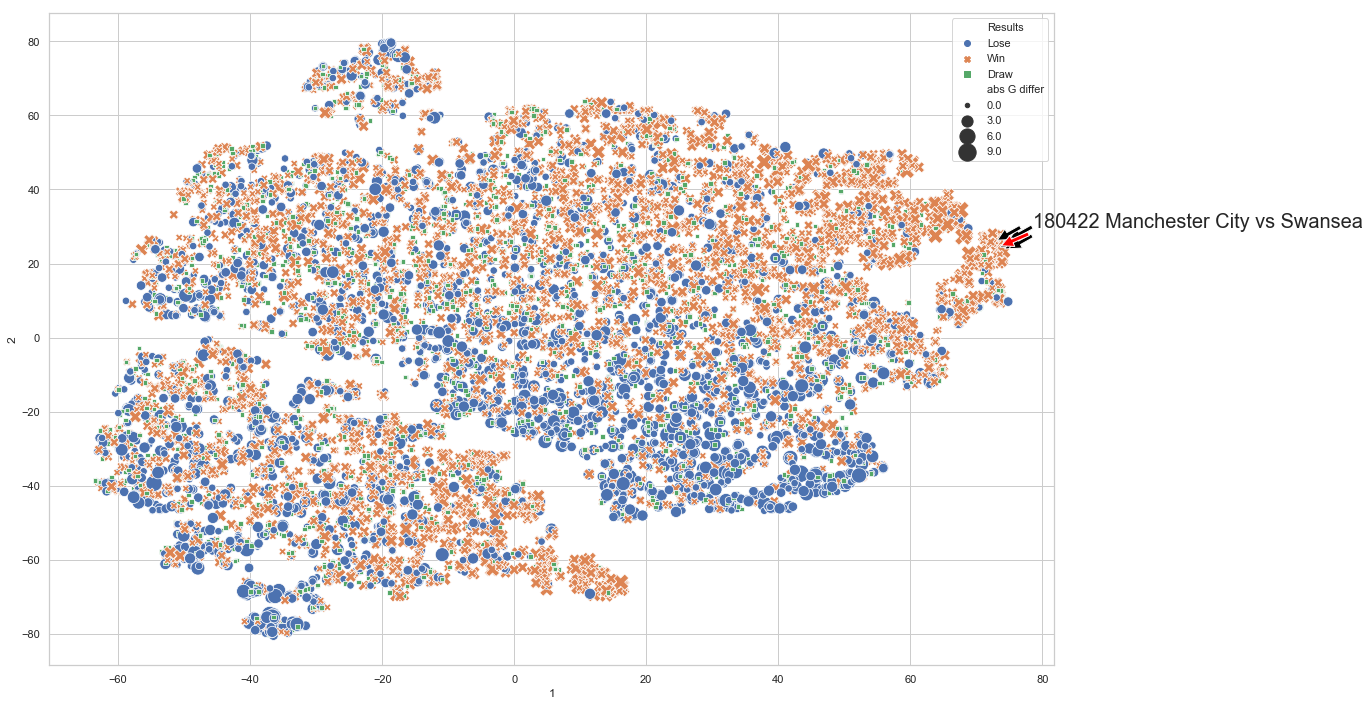

In [20]:
date_ = 180422
home_ = 'Manchester City'
get_similar_matches(transformed, date_, home_, topn=10, print_plt=True)

In [21]:
def get_similar_matches_prob(data_, date, home_team, topn = 10):
    xy = data_[['1', '2']].values
    target_match = data_[['1', '2']][(data_['Match_Date'] == date) & (data_['Home'] == home_team)].values
    similar_list = list(Euclidean(target_match[0], xy))
    similar_list.sort(reverse=False)
    target_index = similar_list[0][1]
    similar_list = similar_list[1 :topn +1]
    distance, results = [], []

    for i in similar_list:
        index = i[1]
        distance.append(i[0])
        
        if data_.loc[index, 'Home_GF'] == data_.loc[index, 'Away_GF']: results.append(1)
        elif data_.loc[index, 'Home_GF'] > data_.loc[index, 'Away_GF']: results.append(0)
        else: results.append(2)
        
 
    predict = list(predict_match(results, distance))[0]

    yield predict

In [47]:
Y = []

for i in data2.loc[:,'Result']:
    if i == 'A': Y.append(2)
    elif i == 'D': Y.append(1)
    else: Y.append(0)

In [52]:
def get_prediction_prob(data2):
    count = 0
    prediction_list = []
    loop = data2.shape[0]
    for idx, (date, team) in enumerate(zip(data2.loc[:loop-1, 'Match_Date'], data2.loc[:loop-1, 'Home_Name'])):
        prediction = list(get_similar_matches_prob(transformed, date, team))[0]
         
        if idx == 0: 
            holder = prediction
            sys.stdout.write('\r{} / {}'.format(holder.shape[0], loop))
        else: 
            holder = np.vstack([holder, prediction])
            sys.stdout.write('\r{} / {}'.format(holder.shape[0], loop))
    yield holder

In [53]:
%%time
resultprob = list(get_prediction_prob(data2))[0]

11751 / 11751Wall time: 1h 5min 51s


In [59]:
predictionlist = np.argmax(resultprob, axis=1)

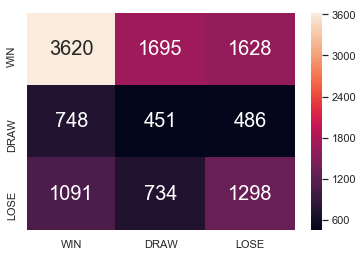

In [60]:
from sklearn.metrics import confusion_matrix
target_name = ['WIN', 'DRAW', 'LOSE']
cm = pd.DataFrame(confusion_matrix(predictionlist, Y), columns=target_name, index=target_name)
sns.heatmap(cm, annot=True, fmt="d")

In [54]:
with open('data/pickle/SMPM.pkl', 'wb') as f:
    pickle.dump(resultprob, f)

In [61]:
(3620 + 451 + 1298)/11751

0.4568972853374181

In [63]:
from sklearn.metrics import classification_report
print(classification_report(predictionlist, Y), '\n')

             precision    recall  f1-score   support

          0       0.66      0.52      0.58      6943
          1       0.16      0.27      0.20      1685
          2       0.38      0.42      0.40      3123

avg / total       0.52      0.46      0.48     11751
 

